In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!pip install transformers==4.0 contractions torch==1.3.1
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased')
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torch import nn, cuda
import pandas as pd
import numpy as np
from sklearn import metrics
import matplotlib.gridspec as gridspec

import seaborn
import transformers
import torch
import nltk
import re
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download("stopwords")
from nltk.stem import PorterStemmer
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, BertConfig
from torch import cuda, nn
import torch
device = 'cuda' if cuda.is_available() else 'cpu'

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_csv("/content/drive/MyDrive/punctuation data/aze_ds_ds.csv")
df.drop(columns=["text", "Unnamed: 0"], axis=1, inplace=True)
df.head()

,clean_txt
0,fenitləşmə qələvi süxurlar intruziyalarının ek...
1,qələvi süxur massivlərin yerləşməsini tənzim p...
2,"i̇lkin süxurların qələvi çöl şpatı, egirin yax..."
3,hornblend biotit egirinə keçir. \n
4,kaliumlu çöl şpatı bulanlıqlaşır. plagioklaz n...


In [3]:
def plotCurves(stats, path, f1=False):
    fig = plt.figure(constrained_layout=True)
    spec2 = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)
    ax1 = fig.add_subplot(spec2[0, 0])
    ax2 = fig.add_subplot(spec2[0, 1])
    ax3 = fig.add_subplot(spec2[1, 0])
    for i in ['train_loss', 'valid_loss']: 
      ax1.plot(stats[i], label=i)
    ax1.legend()
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')

    for j in ['train_acc', 'valid_acc']: 
      ax2.plot(100 * stats[j], label=j)
    ax2.legend()
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    
    if f1:
        for c in ['train_f1', 'valid_f1']: 
          ax3.plot(stats[c], label=c)
        ax3.legend()
        ax3.set_xlabel('Epochs')
        ax3.set_ylabel('F1 Score')
    fig.savefig(path+'/Metrics.png')

In [4]:
def removeDigits(string):
  string = string.lower().replace("\n", "")
  return ''.join(i for i in string if not i.isdigit())

def getLength(string):
  return len(string.split(" "))

In [5]:
# Remove empty string from list
def removeEmpty(li):
  while("" in li) :
      li.remove("")
  while(" " in li) :
      li.remove(" ")
  return li

# Remove other punctuations
def removePunct(sent):
  updt = sent.replace(':','').replace(';','').replace("'",'').replace('"','').replace('(','').replace(')','').replace('_','').replace('/','').replace('__','')
  return updt

In [6]:
def labels(samples):
  li = []
  for each in samples:
    each = each.strip()
    if "," in each:
      li.append(1)
    elif "?" in each:
      li.append(2)
    elif "." in each:
      li.append(3)
    elif "!" in each:
      li.append(4)  
    else: li.append(0)
  return li

In [7]:
# Remove Digits
df["clean_txt"] = df["clean_txt"].apply(lambda x: removeDigits(x))
# Remove punctuations
df["clean_txt"] = df["clean_txt"].apply(lambda x: removePunct(x))
# Splitting into tokens
df["tokens"] = df['clean_txt'].apply(lambda x: x.split(" "))
df.head()

,clean_txt,tokens
0,fenitləşmə qələvi süxurlar intruziyalarının ek...,"[fenitləşmə, qələvi, süxurlar, intruziyalarını..."
1,qələvi süxur massivlərin yerləşməsini tənzim p...,"[qələvi, süxur, massivlərin, yerləşməsini, tən..."
2,"i̇lkin süxurların qələvi çöl şpatı, egirin yax...","[i̇lkin, süxurların, qələvi, çöl, şpatı,, egir..."
3,hornblend biotit egirinə keçir.,"[hornblend, biotit, egirinə, keçir., ]"
4,kaliumlu çöl şpatı bulanlıqlaşır. plagioklaz n...,"[kaliumlu, çöl, şpatı, bulanlıqlaşır., plagiok..."


In [8]:
# Remove EMPTY
df['new_tokens'] = df['tokens'].apply(lambda x: removeEmpty(x))
# Getting length
df['length'] = df['tokens'].apply(lambda x: len(x))
# Create Labels
df['labels'] = df['tokens'].apply(lambda x: labels(x))

In [9]:
df.drop(['clean_txt', 'tokens'], axis=1, inplace=True) 
df.head()

,new_tokens,length,labels
0,"[fenitləşmə, qələvi, süxurlar, intruziyalarını...",16,"[0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 3]"
1,"[qələvi, süxur, massivlərin, yerləşməsini, tən...",9,"[0, 0, 0, 0, 0, 0, 0, 0, 3]"
2,"[i̇lkin, süxurların, qələvi, çöl, şpatı,, egir...",10,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 3]"
3,"[hornblend, biotit, egirinə, keçir.]",4,"[0, 0, 0, 3]"
4,"[kaliumlu, çöl, şpatı, bulanlıqlaşır., plagiok...",7,"[0, 0, 0, 3, 0, 0, 3]"


In [10]:
# Using data with length more than 50
df=df[df['length'] > 50]
len(df)

20054

## Model Class

In [11]:
# # Create a yaml file by name of model.yanl and put this in that 
# debug:
#   summary_writer: true
#   break_train_loop: false

# experiment:
#   name: bert-base-multilingual-uncased-unfreezed

# data:
#   data_path: /userhome/student/bial/neural-punctuator/data/bert-base-multilingual-uncased/
#   output_labels: [empty, period, question, comma]

# preprocessor:
#   preproc_arg: TODO

# model:
#   name: szeged
#   load_model_repo: bert-base-multilingual-uncased
#   bert_output_dim: 768
#   linear_hidden_dim: 2048
#   num_classes: 5
#   seq_len: 512
#   dropout: 0.2

#   save_model_path: /userhome/student/bial/neural-punctuator/models/

# trainer:
#   use_gpu: cuda:0
#   batch_size: 4
#   num_epochs: 12
#   shuffle: true
#   optimizer: adamw
#   loss: NLLLoss
#   base_learning_rate: 0.00003 #3e-5
#   classifier_learning_rate: 0.0001 #1e-4
#   metrics: [precision, recall, f-score, auc]
#   warmup_steps: 300
#   clip_seq: 32
#   grad_clip: 1.5
#   train_bert: true
#   #load_model:
#   seq_shift: 32   # Shift each training sample +-seq_shift to get more different samples
#   show_confusion_matrix: false

In [12]:
!pip install dotmap
import logging
import sys
import numpy as np
from abc import abstractmethod
import torch
import torch.nn as nn


handler = logging.StreamHandler(sys.stdout)
handler.setFormatter(logging.Formatter('%(asctime)s %(levelname)-9s %(message)s'))

log = logging.getLogger(__name__)
log.setLevel(logging.INFO)
log.addHandler(handler)


class BaseModel(nn.Module):
    """
    Base class for all torch models
    """
    def __init__(self, config):
        super().__init__()
        self._config = config

    @abstractmethod
    def forward(self, *inputs):
        """
        Forward pass logic
        :return: Model output
        """
        raise NotImplementedError

    def __str__(self):
        """
        Model prints with number of trainable parameters
        """
        model_parameters = filter(lambda p: p.requires_grad, self.parameters())
        params = sum([np.prod(p.size()) for p in model_parameters])
        return super().__str__() + '\nTrainable parameters: {}'.format(params)

    def save_model(self, optimizer, epoch):
        log.info("Saving model...")
        torch.save(self.state_dict(), f'saved/models/{self._config.model.name}_{str(epoch)}.pth')
        torch.save(optimizer.state_dict(), f'saved/models/{self._config.model.name}_{str(epoch)}_optimizer_state.pth')

    def load_model(self, optimizer, epoch, model_name):
        log.info("Loading model...")
        self.load_state_dict(torch.load(f'saved/models/{model_name}_{str(epoch)}.pth'))
        optimizer.load_state_dict(torch.load(f'saved/models/{model_name}_{str(epoch)}_optimizer_state.pth'))

from typing import Any

import torch
from torch import nn
import torch.nn.functional as F


from transformers import AutoTokenizer, AutoModel


class BertPunctuator(BaseModel):
    def __init__(self, config):
        super().__init__(config)
        # self.base = torch.hub.load(self._config.model.bert_github_repo, 'model', self._config.model.bert_variant_to_load)
        self.base = AutoModel.from_pretrained(self._config.model.load_model_repo)

        if not self._config.trainer.train_bert:
            for param in self.base.parameters():
                param.requires_grad = False

        self.classifier = Classifier(self._config)

    def forward(self, x, y):
        if self._config.trainer.train_bert:
            embedding, _ = self.base(input_ids=x, attention_mask=y, return_dict=False)
        else:
            with torch.no_grad():
                embedding, _ = self.base(input_ids=x, attention_mask=y, return_dict=False)

        output = self.classifier(embedding)
        output = F.log_softmax(output, dim=-1)
        return output

    def train(self, mode=True):
        if mode:
            if self._config.trainer.train_bert:
                self.base.train()
            else:
                self.base.eval()
            self.classifier.train()
        else:
            self.base.eval()
            self.classifier.eval()
        return self

    def eval(self):
        self.train(False)
        return self


class Classifier(BaseModel):
    def __init__(self, config):
        super().__init__(None)
        self.dropout1 = nn.Dropout(0.1)
        self.linear1 = nn.Linear(config.model.bert_output_dim, config.model.linear_hidden_dim)
        self.activation = nn.ReLU()
        self.dropout2 = nn.Dropout(0.1)
        self.linear2 = nn.Linear(config.model.linear_hidden_dim, config.model.num_classes)

    def forward(self, x):
        x = self.dropout1(x)
        x = self.activation(self.linear1(x))
        x = self.dropout2(x)
        x = self.linear2(x)
        return x


import yaml
from dotmap import DotMap
def get_config_from_yaml(yaml_file):
    with open(yaml_file, 'r') as config_file:
        config_yaml = yaml.load(config_file)
    # Using DotMap we will be able to reference nested parameters via attribute such as x.y instead of x['y']
    config = DotMap(config_yaml)
    return config

  

In [13]:
config = get_config_from_yaml('/content/drive/MyDrive/punctuation data/model.yaml')
model = BertPunctuator(config)
model.to(device)

BertPunctuator(
  (base): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

## Our Dataset

In [14]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, label, device):
        # super(CustomDataset, self).__init__(dataframe, label)
        self.dataframe = dataframe
        self.ids = self.dataframe['input_ids'].values.tolist()
        self.mask = self.dataframe['attention_mask'].values.tolist()
        self.targets = label.values.tolist()
       
    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):

        ids = self.ids[index]
        mask = self.mask[index]
        t_value = self.targets[index]       #index by iteration
        return {
            'ids': torch.tensor(ids, dtype=torch.long).to(device, dtype = torch.long),
            'mask': torch.tensor(mask, dtype=torch.long).to(device, dtype = torch.long),
            'targets': torch.tensor(t_value, dtype=torch.long).to(device)
        }
        

## initializing tokenizers

In [15]:
from transformers import AutoTokenizer
model_checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
import transformers
assert isinstance(tokenizer, transformers.PreTrainedTokenizerFast)

In [16]:
label_all_tokens = True
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(list(examples['new_tokens']), truncation=True, is_split_into_words=True, max_length=512, pad_to_max_length=True)
    labels = []
    for i, label in enumerate(examples["labels"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            # Special tokens have a word id that is None. We set the label to -100 so they are automatically
            # ignored in the loss function.
            if word_idx is None:
                label_ids.append(0)
            # We set the label for the first token of each word.
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            # For the other tokens in a word, we set the label to either the current label or -100, depending on
            # the label_all_tokens flag.
            else:
                label_ids.append(label[word_idx] if label_all_tokens else 0)
            previous_word_idx = word_idx

        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [17]:
df.head()

,new_tokens,length,labels
171,"[birləşmiş, nüvə, araşdırma, i̇nstitutu, qısac...",55,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
177,"[bnai̇nun, yaradılması, ərəfəsində, yüklənmiş,...",123,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
181,"[nailiyyətlər., ci, ildə,, bnai̇nun, mükafatla...",115,"[3, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, ..."
323,"[müharibə, dünyanın, böyük, uzunmüddətli, kred...",58,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
331,"[soyuq, müharibə, sona, ci, sovet, i̇ttifaqı, ...",73,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [18]:
inputs = tokenize_and_align_labels(df)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [19]:
inputs.keys()

dict_keys(['input_ids', 'attention_mask', 'labels'])

In [20]:
df_train = pd.DataFrame.from_dict(inputs, orient='index')
df_train = df_train.T
df_train.head()

,input_ids,attention_mask,labels
0,"[101, 12170, 12190, 29681, 6491, 2483, 16371, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[101, 24869, 8113, 4609, 8038, 12173, 11722, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[101, 13774, 28008, 2100, 29681, 19646, 29681,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 3, 3, 3, 3, 3, 3, 3, 3, 0, 1, 1, 1, 1, 0, ..."
3,"[101, 14163, 18428, 2497, 29681, 24654, 7054, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[101, 25176, 2226, 4160, 14163, 18428, 2497, 2...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [21]:
L = ['input_ids','attention_mask','labels']
for z in L:
  for i in df_train[z]:
    if len(i) != 512:
      print('error')

## Data splitting

In [23]:
X_train, X_test, y_train, y_test = train_test_split(df_train.drop(columns = 'labels', axis=1), df_train['labels'], test_size=0.40, random_state=42)

## now creating custom classes.

In [24]:
TRAIN_BATCH_SIZE = 6
VALID_BATCH_SIZE = 6
training_set = CustomDataset(X_train, y_train, device)
testing_set = CustomDataset(X_test, y_test, device)
training_loader = DataLoader(training_set, batch_size = TRAIN_BATCH_SIZE, num_workers=0, shuffle = True)
testing_loader = DataLoader(testing_set, batch_size = VALID_BATCH_SIZE, num_workers=0, shuffle = True)

In [25]:
# model = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=2)
# model.to(device)

In [26]:
LEARNING_RATE = 0.00003
criterion = nn.BCEWithLogitsLoss()     # we can use it for cross entropy loss. in case of focal loss we don't need this
optimizer = torch.optim.SGD(params =  model.parameters(), lr=LEARNING_RATE, momentum=0.8)

In [27]:
# inp = next(iter(training_loader))
# ids = inp["ids"].to(device, dtype = torch.long)
# mask = inp["mask"].to(device, dtype = torch.long)
# lbl = inp["targets"].to(device, dtype = torch.long)
# outputs = model(ids, mask)
# softm = torch.nn.Softmax(dim=1)
# pred = torch.argmax(softm(outputs.logits), dim=2).detach().cpu().numpy()
# label = lbl.detach().cpu().numpy()

In [ ]:
# f1_score(label.flatten(), pred.flatten(), average='weighted')

In [ ]:
# f1=[]
# for i, _ in enumerate(range(label.shape[0])):
#   f1.append(f1_score(label[i], pred[i], average='weighted'))
# np.mean(f1)

In [ ]:
# print(lbl.shape)
# print(outputs.logits.shape)
# targets = torch.nn.functional.one_hot(lbl, 5)
# print(targets.shape)
# # loss = criterion(outputs, targets)

In [28]:
def CallsTrain(Model, trainloader, testloader, Epochs, name):  
    stats = []
    for epoch in range(1, Epochs):  # loop over the dataset multiple times
        train_loss, running_loss = 0.0, 0.0
        valid_loss, val_loss = 0.0, 0.0
        t_accuracy, v_accuracy = [], []
        t_f1, v_f1 = [], []
        Model.train()
        cls_preds, cls_tars = [], [] 
        tr_pbar = tqdm(enumerate(trainloader, 0)) 
        for tr_batch, data in tr_pbar:    # Getting the batches every iteration
            tr_pbar.set_description(f'Epoch no: {epoch}/{Epochs} Training batch no {tr_batch}')
            ids = data['ids']
            masks = data['mask']
            target = torch.nn.functional.one_hot(data['targets'], 5)
            one_hot = target.to(device, dtype = torch.float)
            optimizer.zero_grad()
            outputs = Model(ids, masks)
            # loss = criterion(outputs.logits, one_hot)   #----> compute loss
            loss = criterion(outputs, one_hot)   #----> compute loss

            loss.backward()                     #----> backward pass
            optimizer.step()                   #----> weights update

            softm = torch.nn.Softmax(dim=1)
            # preds = torch.argmax(softm(outputs.logits),dim=2).cpu().detach().numpy()
            preds = torch.argmax(softm(outputs),dim=2).cpu().detach().numpy()

            acc = accuracy_score(data['targets'].flatten().cpu().numpy(), preds.flatten())
            t_accuracy.append(acc)
            f1 = f1_score(data['targets'].flatten().cpu().numpy(), preds.flatten(), average='weighted')
            t_f1.append(f1)
            running_loss += loss.item()        # Adding loss for every batch size
        epoch_acc = np.mean(t_accuracy)
        epoch_f1 = np.mean(t_f1)
        train_loss = running_loss / len(trainloader)

        # with torch.no_grad():
        Model.eval()
        val_pbar = tqdm(enumerate(testloader, 0)) 
        for val_batch, v_data in val_pbar:
            val_pbar.set_description(f'Epoch no: {epoch}/{Epochs} Validation batch no {val_batch}')
            id = v_data['ids']
            mask = v_data['mask']
            targets = torch.nn.functional.one_hot(v_data['targets'], 5)
            one_hot = targets.to(device, dtype = torch.float)
            optimizer.zero_grad()
            out = Model(id, mask)
            # loss = criterion(out.logits, one_hot)   #----> compute loss
            loss = criterion(out, one_hot)
            
            # v_preds = torch.argmax(softm(out.logits),dim=2).cpu().detach().numpy()
            v_preds = torch.argmax(softm(out),dim=2).cpu().detach().numpy()
            acc = accuracy_score(v_data['targets'].flatten().cpu().numpy(), v_preds.flatten())
            v_accuracy.append(acc)
            vf1 = f1_score(v_data['targets'].flatten().cpu().numpy(), v_preds.flatten(), average='weighted')
            v_f1.append(vf1)
            val_loss += loss.item()
            cls_tars.extend(v_data['targets'].cpu().numpy())
            cls_preds.extend(v_preds)

        epoch_vacc = np.mean(v_accuracy)
        epoch_vf1 = np.mean(v_f1)        
        valid_loss = val_loss / len(testloader)

        print(f'\nTraining loss: {train_loss}, Training Accuracy: {100*epoch_acc}, Training F1 Score: {epoch_f1}')
        print(f'Validation loss: {valid_loss}, Validation Accuracy: {100*epoch_vacc}, Validation F1 Score: {epoch_vf1}')
        print(f'Precision: {precision_score(np.array(cls_tars).flatten(), np.array(cls_preds).flatten(), zero_division=1, average="weighted")}')
        print(f'\nRecall: {recall_score(np.array(cls_tars).flatten(), np.array(cls_preds).flatten(), zero_division=1, average="weighted")}\n')

        stats.append([train_loss, valid_loss, epoch_acc, epoch_vacc, epoch_f1, epoch_vf1])
        history = pd.DataFrame(stats, columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc', 'train_f1', 'valid_f1'])
        torch.save(model.state_dict(), name)
        history.to_csv("/content/drive/MyDrive/punctuation data/history.csv")
        if epoch % 5 == 0: plotCurves(history, '/content/drive/MyDrive/punctuation data/', True)
    return model, history

Epoch no: 1/50 Training batch no 2005: : 2006it [12:41,  2.63it/s]
Epoch no: 1/50 Validation batch no 1336: : 1337it [02:53,  7.72it/s]



Training loss: 0.30687193670574714, Training Accuracy: 36.62383617377036, Training F1 Score: 0.49243761068549086
Validation loss: 0.23006778097277536, Validation Accuracy: 58.3206728371977, Validation F1 Score: 0.695799909446828
Precision: 0.8723254624526777

Recall: 0.5832067283719771



Epoch no: 2/50 Training batch no 2005: : 2006it [12:41,  2.63it/s]
Epoch no: 2/50 Validation batch no 1336: : 1337it [02:52,  7.74it/s]



Training loss: 0.22862150129357933, Training Accuracy: 44.711162735751074, Training F1 Score: 0.581548985925866
Validation loss: 0.22453499875723112, Validation Accuracy: 59.76245987596609, Validation F1 Score: 0.70753480483657
Precision: 0.878347790835063

Recall: 0.5976245987596609



Epoch no: 3/50 Training batch no 2005: : 2006it [12:41,  2.64it/s]
Epoch no: 3/50 Validation batch no 1336: : 1337it [02:52,  7.76it/s]



Training loss: 0.22459479188128698, Training Accuracy: 49.85463531281156, Training F1 Score: 0.6283344002301731
Validation loss: 0.22108247870594686, Validation Accuracy: 60.01946794751931, Validation F1 Score: 0.7103357462872899
Precision: 0.8831375599525076

Recall: 0.6001946794751932



Epoch no: 4/50 Training batch no 2005: : 2006it [12:40,  2.64it/s]
Epoch no: 4/50 Validation batch no 1336: : 1337it [02:52,  7.76it/s]



Training loss: 0.2217766200438335, Training Accuracy: 53.46139316425723, Training F1 Score: 0.6595230660817206
Validation loss: 0.2185597278640265, Validation Accuracy: 59.89812196148093, Validation F1 Score: 0.7099388903517097
Precision: 0.8863229652842685

Recall: 0.5989812196148093



Epoch no: 5/50 Training batch no 2005: : 2006it [12:41,  2.63it/s]
Epoch no: 5/50 Validation batch no 1336: : 1337it [02:53,  7.70it/s]



Training loss: 0.21949604559218064, Training Accuracy: 55.77143893839316, Training F1 Score: 0.6787309311325778
Validation loss: 0.21639539419534765, Validation Accuracy: 59.755496603091494, Validation F1 Score: 0.7093396138028142
Precision: 0.888688065267403

Recall: 0.597554966030915



Epoch no: 6/50 Training batch no 2005: : 2006it [12:41,  2.63it/s]
Epoch no: 6/50 Validation batch no 1336: : 1337it [02:53,  7.70it/s]



Training loss: 0.21745997673255257, Training Accuracy: 57.188850116317724, Training F1 Score: 0.6901730165589822
Validation loss: 0.21447068087271817, Validation Accuracy: 59.9111233171279, Validation F1 Score: 0.7105871210309533
Precision: 0.8905111597962512

Recall: 0.599111233171279



Epoch no: 7/50 Training batch no 2005: : 2006it [12:41,  2.63it/s]
Epoch no: 7/50 Validation batch no 1336: : 1337it [02:53,  7.70it/s]



Training loss: 0.21558128997074405, Training Accuracy: 58.15423196556164, Training F1 Score: 0.6978981560026936
Validation loss: 0.21264358710779035, Validation Accuracy: 60.36044919440289, Validation F1 Score: 0.7141605823697347
Precision: 0.8921049632762277

Recall: 0.6036044919440289



Epoch no: 8/50 Training batch no 2005: : 2006it [12:41,  2.63it/s]
Epoch no: 8/50 Validation batch no 1336: : 1337it [02:52,  7.76it/s]



Training loss: 0.21373052490227007, Training Accuracy: 58.90948573550182, Training F1 Score: 0.7038148160081278
Validation loss: 0.21079052203434478, Validation Accuracy: 61.20044876589379, Validation F1 Score: 0.7205508487665717
Precision: 0.893667408522774

Recall: 0.6120044876589379



Epoch no: 9/50 Training batch no 2005: : 2006it [12:40,  2.64it/s]
Epoch no: 9/50 Validation batch no 1336: : 1337it [02:52,  7.76it/s]



Training loss: 0.2118612910627368, Training Accuracy: 59.7472394015869, Training F1 Score: 0.7103310861803908
Validation loss: 0.20874526973036392, Validation Accuracy: 62.365701352530536, Validation F1 Score: 0.7293614093756626
Precision: 0.895420358717266

Recall: 0.6236570135253054



Epoch no: 10/50 Training batch no 2005: : 2006it [12:40,  2.64it/s]
Epoch no: 10/50 Validation batch no 1336: : 1337it [02:52,  7.76it/s]



Training loss: 0.20983434157262176, Training Accuracy: 60.854578192505805, Training F1 Score: 0.7188574468195175
Validation loss: 0.20651619883063307, Validation Accuracy: 64.21795628428072, Validation F1 Score: 0.7430605697824311
Precision: 0.8972856155782797

Recall: 0.6421795628428073



Epoch no: 11/50 Training batch no 2005: : 2006it [12:40,  2.64it/s]
Epoch no: 11/50 Validation batch no 1336: : 1337it [02:52,  7.73it/s]



Training loss: 0.20763474731062606, Training Accuracy: 62.42176789942672, Training F1 Score: 0.7305906282753097
Validation loss: 0.204058373841494, Validation Accuracy: 66.64219782317377, Validation F1 Score: 0.7607119344855301
Precision: 0.899624336041781

Recall: 0.6664219782317378



Epoch no: 12/50 Training batch no 2005: : 2006it [12:41,  2.63it/s]
Epoch no: 12/50 Validation batch no 1336: : 1337it [02:52,  7.73it/s]



Training loss: 0.2052238826841443, Training Accuracy: 64.61343508536889, Training F1 Score: 0.7466659623556525
Validation loss: 0.20139026647418315, Validation Accuracy: 69.91556909904013, Validation F1 Score: 0.7837682382836066
Precision: 0.9024687404983011

Recall: 0.6991556909904014



Epoch no: 13/50 Training batch no 2005: : 2006it [12:40,  2.64it/s]
Epoch no: 13/50 Validation batch no 1336: : 1337it [02:52,  7.77it/s]



Training loss: 0.20249945937042102, Training Accuracy: 67.45919468158026, Training F1 Score: 0.7670985410850729
Validation loss: 0.19841358454573396, Validation Accuracy: 73.79676592495636, Validation F1 Score: 0.8104741388193728
Precision: 0.9060872231364603

Recall: 0.7379676592495636



Epoch no: 14/50 Training batch no 2005: : 2006it [12:40,  2.64it/s]
Epoch no: 14/50 Validation batch no 1336: : 1337it [02:52,  7.77it/s]



Training loss: 0.19947900409891028, Training Accuracy: 70.9373507082918, Training F1 Score: 0.7913959375230389
Validation loss: 0.1951227645733148, Validation Accuracy: 77.76059683526552, Validation F1 Score: 0.8371509883270186
Precision: 0.9106995308688277

Recall: 0.7776059683526552



Epoch no: 15/50 Training batch no 2005: : 2006it [12:40,  2.64it/s]
Epoch no: 15/50 Validation batch no 1336: : 1337it [02:52,  7.77it/s]



Training loss: 0.1963102975609533, Training Accuracy: 74.58097712072116, Training F1 Score: 0.8162600616497984
Validation loss: 0.19174680854949652, Validation Accuracy: 81.0934967900773, Validation F1 Score: 0.859445984507334
Precision: 0.915950472535207

Recall: 0.8109349679007729



Epoch no: 16/50 Training batch no 2005: : 2006it [12:40,  2.64it/s]
Epoch no: 16/50 Validation batch no 1336: : 1337it [02:52,  7.77it/s]



Training loss: 0.1931110129191179, Training Accuracy: 77.92022694936026, Training F1 Score: 0.8386010898420141
Validation loss: 0.1884168041514744, Validation Accuracy: 83.45704098884319, Validation F1 Score: 0.8754869106257573
Precision: 0.9214109773911976

Recall: 0.8345704098884318



Epoch no: 17/50 Training batch no 2005: : 2006it [12:40,  2.64it/s]
Epoch no: 17/50 Validation batch no 1336: : 1337it [02:52,  7.77it/s]



Training loss: 0.18997168555068353, Training Accuracy: 80.72759261278664, Training F1 Score: 0.8573368625353155
Validation loss: 0.18512754680598595, Validation Accuracy: 85.19596013307155, Validation F1 Score: 0.8877139761446337
Precision: 0.9270882001348626

Recall: 0.8519596013307156



Epoch no: 18/50 Training batch no 2005: : 2006it [12:40,  2.64it/s]
Epoch no: 18/50 Validation batch no 1336: : 1337it [02:52,  7.77it/s]



Training loss: 0.1868699258146947, Training Accuracy: 83.04933831318544, Training F1 Score: 0.8730293433990822
Validation loss: 0.18200170162371404, Validation Accuracy: 86.85278082928197, Validation F1 Score: 0.8996029779036873
Precision: 0.933335875430052

Recall: 0.8685278082928197



Epoch no: 19/50 Training batch no 2005: : 2006it [12:40,  2.64it/s]
Epoch no: 19/50 Validation batch no 1336: : 1337it [02:52,  7.75it/s]



Training loss: 0.18401464984073476, Training Accuracy: 84.96225191612662, Training F1 Score: 0.8862230304517762
Validation loss: 0.1791802388389519, Validation Accuracy: 88.09058779761905, Validation F1 Score: 0.9086937893669327
Precision: 0.9387522504569976

Recall: 0.8809058779761905



Epoch no: 20/50 Training batch no 2005: : 2006it [12:41,  2.64it/s]
Epoch no: 20/50 Validation batch no 1336: : 1337it [02:52,  7.75it/s]



Training loss: 0.18137257828461684, Training Accuracy: 86.45968020417914, Training F1 Score: 0.8967600437522791
Validation loss: 0.17674794268189034, Validation Accuracy: 89.17035768823234, Validation F1 Score: 0.9165892936602238
Precision: 0.9434645258086546

Recall: 0.8917035768823236



Epoch no: 21/50 Training batch no 2005: : 2006it [12:40,  2.64it/s]
Epoch no: 21/50 Validation batch no 1336: : 1337it [02:52,  7.75it/s]



Training loss: 0.17909368536883552, Training Accuracy: 87.62845577849782, Training F1 Score: 0.9051413609961075
Validation loss: 0.17461109108994413, Validation Accuracy: 90.03709038425579, Validation F1 Score: 0.9228822005122321
Precision: 0.9472953231920123

Recall: 0.9003709038425579



Epoch no: 22/50 Training batch no 2005: : 2006it [12:40,  2.64it/s]
Epoch no: 22/50 Validation batch no 1336: : 1337it [02:52,  7.76it/s]



Training loss: 0.17709307238117886, Training Accuracy: 88.5770260832087, Training F1 Score: 0.9120118743499691
Validation loss: 0.1727456576514797, Validation Accuracy: 90.72798826664173, Validation F1 Score: 0.9278619824336874
Precision: 0.9503228585587035

Recall: 0.9072798826664173



Epoch no: 23/50 Training batch no 2005: : 2006it [12:40,  2.64it/s]
Epoch no: 23/50 Validation batch no 1336: : 1337it [02:52,  7.75it/s]



Training loss: 0.17528408334208867, Training Accuracy: 89.30912341101694, Training F1 Score: 0.9172266968296919
Validation loss: 0.1710395902930219, Validation Accuracy: 91.26087341841188, Validation F1 Score: 0.9316689840996846
Precision: 0.9526544833891238

Recall: 0.9126087341841187



Epoch no: 24/50 Training batch no 2005: : 2006it [12:40,  2.64it/s]
Epoch no: 24/50 Validation batch no 1336: : 1337it [02:52,  7.75it/s]



Training loss: 0.17365223783646838, Training Accuracy: 89.91401446701562, Training F1 Score: 0.9215917739140138
Validation loss: 0.16941553793385034, Validation Accuracy: 91.75743268511593, Validation F1 Score: 0.93515224663852
Precision: 0.9547444022413625

Recall: 0.9175743268511594



Epoch no: 25/50 Training batch no 2005: : 2006it [12:40,  2.64it/s]
Epoch no: 25/50 Validation batch no 1336: : 1337it [02:52,  7.76it/s]



Training loss: 0.17207405394535596, Training Accuracy: 90.45613809612829, Training F1 Score: 0.9254704063446456
Validation loss: 0.16794149398179578, Validation Accuracy: 92.06673834455249, Validation F1 Score: 0.9373409963309719
Precision: 0.956145382703845

Recall: 0.9206673834455248



Epoch no: 26/50 Training batch no 2005: : 2006it [12:40,  2.64it/s]
Epoch no: 26/50 Validation batch no 1336: : 1337it [02:52,  7.76it/s]



Training loss: 0.17063517277226492, Training Accuracy: 90.90626882373712, Training F1 Score: 0.928678473349112
Validation loss: 0.16647299419790396, Validation Accuracy: 92.41219945929942, Validation F1 Score: 0.939782627060011
Precision: 0.9576002678420474

Recall: 0.9241219945929943



Epoch no: 27/50 Training batch no 2005: : 2006it [12:40,  2.64it/s]
Epoch no: 27/50 Validation batch no 1336: : 1337it [02:52,  7.76it/s]



Training loss: 0.16922236513996408, Training Accuracy: 91.32181904806413, Training F1 Score: 0.931617685124001
Validation loss: 0.16521565748758965, Validation Accuracy: 92.56626795842682, Validation F1 Score: 0.9407696680479587
Precision: 0.9583149555710853

Recall: 0.9256626795842683



Epoch no: 28/50 Training batch no 2005: : 2006it [12:40,  2.64it/s]
Epoch no: 28/50 Validation batch no 1336: : 1337it [02:52,  7.76it/s]



Training loss: 0.16791445612610278, Training Accuracy: 91.66387556081754, Training F1 Score: 0.9340345783210814
Validation loss: 0.1640730610224589, Validation Accuracy: 92.75525021035901, Validation F1 Score: 0.9420576186566747
Precision: 0.9590776516036602

Recall: 0.9275525021035901



Epoch no: 29/50 Training batch no 2005: : 2006it [12:40,  2.64it/s]
Epoch no: 29/50 Validation batch no 1336: : 1337it [02:52,  7.76it/s]



Training loss: 0.16668910104577112, Training Accuracy: 91.9771609650216, Training F1 Score: 0.9362498970621478
Validation loss: 0.16302472788759728, Validation Accuracy: 92.93103632978061, Validation F1 Score: 0.943209651212526
Precision: 0.9597339384720528

Recall: 0.929310363297806



Epoch no: 30/50 Training batch no 2005: : 2006it [12:40,  2.64it/s]
Epoch no: 30/50 Validation batch no 1336: : 1337it [02:52,  7.76it/s]



Training loss: 0.16556423817829025, Training Accuracy: 92.26297344944334, Training F1 Score: 0.9382977480792589
Validation loss: 0.16211296820827803, Validation Accuracy: 93.074708613812, Validation F1 Score: 0.94417078062527
Precision: 0.9602870516085732

Recall: 0.9307470861381202



Epoch no: 31/50 Training batch no 2005: : 2006it [12:40,  2.64it/s]
Epoch no: 31/50 Validation batch no 1336: : 1337it [02:52,  7.76it/s]



Training loss: 0.16460262001273876, Training Accuracy: 92.5074223942755, Training F1 Score: 0.9400266546479781
Validation loss: 0.16135005581575093, Validation Accuracy: 93.14684909467715, Validation F1 Score: 0.9445917217166445
Precision: 0.9605740247395044

Recall: 0.9314684909467714



Epoch no: 32/50 Training batch no 2005: : 2006it [12:40,  2.64it/s]
Epoch no: 32/50 Validation batch no 1336: : 1337it [02:52,  7.76it/s]



Training loss: 0.16374241911313114, Training Accuracy: 92.7126660383433, Training F1 Score: 0.9414975526868384
Validation loss: 0.16067664465667064, Validation Accuracy: 93.23111443530291, Validation F1 Score: 0.9451342409571195
Precision: 0.9609212435914432

Recall: 0.9323111443530292



Epoch no: 33/50 Training batch no 2005: : 2006it [12:40,  2.64it/s]
Epoch no: 33/50 Validation batch no 1336: : 1337it [02:52,  7.75it/s]



Training loss: 0.16292695047432262, Training Accuracy: 92.88553610003322, Training F1 Score: 0.9427832703974013
Validation loss: 0.1599973922869833, Validation Accuracy: 93.34152856987035, Validation F1 Score: 0.945905569483321
Precision: 0.9613793981055462

Recall: 0.9334152856987036



Epoch no: 34/50 Training batch no 2005: : 2006it [12:40,  2.64it/s]
Epoch no: 34/50 Validation batch no 1336: : 1337it [02:52,  7.76it/s]



Training loss: 0.16224328042978303, Training Accuracy: 93.04149725303257, Training F1 Score: 0.943948377927574
Validation loss: 0.1594567763533446, Validation Accuracy: 93.42705996010969, Validation F1 Score: 0.9465152874925434
Precision: 0.9618057563977171

Recall: 0.9342705996010969



Epoch no: 35/50 Training batch no 2005: : 2006it [12:40,  2.64it/s]
Epoch no: 35/50 Validation batch no 1336: : 1337it [02:52,  7.76it/s]



Training loss: 0.16160054183226163, Training Accuracy: 93.18382742397806, Training F1 Score: 0.9449852483400607
Validation loss: 0.15893480837033058, Validation Accuracy: 93.49610835826478, Validation F1 Score: 0.9470689267568532
Precision: 0.9621814167688217

Recall: 0.9349610835826477



Epoch no: 36/50 Training batch no 2005: : 2006it [12:40,  2.64it/s]
Epoch no: 36/50 Validation batch no 1336: : 1337it [02:52,  7.76it/s]



Training loss: 0.16104606501126695, Training Accuracy: 93.301686736665, Training F1 Score: 0.9459323753441083
Validation loss: 0.15855480706014113, Validation Accuracy: 93.49542663924207, Validation F1 Score: 0.9470688879878266
Precision: 0.9623389904180714

Recall: 0.9349542663924209



Epoch no: 37/50 Training batch no 2005: : 2006it [12:40,  2.64it/s]
Epoch no: 37/50 Validation batch no 1336: : 1337it [02:52,  7.76it/s]



Training loss: 0.16048522805377233, Training Accuracy: 93.39007716434031, Training F1 Score: 0.946634507134351
Validation loss: 0.15812332648435634, Validation Accuracy: 93.55816913643729, Validation F1 Score: 0.9475919064265471
Precision: 0.9627515225063437

Recall: 0.935581691364373



Epoch no: 38/50 Training batch no 2005: : 2006it [12:40,  2.64it/s]
Epoch no: 38/50 Validation batch no 1336: : 1337it [02:52,  7.76it/s]



Training loss: 0.1600120258949333, Training Accuracy: 93.46822812811565, Training F1 Score: 0.9472790524526338
Validation loss: 0.15768047607738578, Validation Accuracy: 93.62665755110946, Validation F1 Score: 0.9481857998684918
Precision: 0.9631966212325012

Recall: 0.9362665755110945



Epoch no: 39/50 Training batch no 2005: : 2006it [12:40,  2.64it/s]
Epoch no: 39/50 Validation batch no 1336: : 1337it [02:52,  7.76it/s]



Training loss: 0.15957941595513228, Training Accuracy: 93.5459571805417, Training F1 Score: 0.9479333791350891
Validation loss: 0.15734881034473386, Validation Accuracy: 93.64287272500623, Validation F1 Score: 0.9483930699581022
Precision: 0.9634741727813438

Recall: 0.9364287272500623



Epoch no: 40/50 Training batch no 2005: : 2006it [12:40,  2.64it/s]
Epoch no: 40/50 Validation batch no 1336: : 1337it [02:52,  7.76it/s]



Training loss: 0.159182603455196, Training Accuracy: 93.60872460742772, Training F1 Score: 0.9484482995688442
Validation loss: 0.1570711276628406, Validation Accuracy: 93.64391965064821, Validation F1 Score: 0.9485117074019044
Precision: 0.9637323942445084

Recall: 0.9364391965064822



Epoch no: 41/50 Training batch no 2005: : 2006it [12:40,  2.64it/s]
Epoch no: 41/50 Validation batch no 1336: : 1337it [02:52,  7.75it/s]



Training loss: 0.1588652020214443, Training Accuracy: 93.64736195060651, Training F1 Score: 0.948807869188682
Validation loss: 0.15677869043514278, Validation Accuracy: 93.63997541915981, Validation F1 Score: 0.9486008912212954
Precision: 0.9639737663097369

Recall: 0.9363997541915982



Epoch no: 42/50 Training batch no 2005: : 2006it [12:41,  2.64it/s]
Epoch no: 42/50 Validation batch no 1336: : 1337it [02:52,  7.75it/s]



Training loss: 0.1584528546004091, Training Accuracy: 93.69787772100365, Training F1 Score: 0.9492989331405927
Validation loss: 0.15642533439616257, Validation Accuracy: 93.69064175081029, Validation F1 Score: 0.9491388007638707
Precision: 0.9644446331378749

Recall: 0.9369064175081027



Epoch no: 43/50 Training batch no 2005: : 2006it [12:40,  2.64it/s]
Epoch no: 43/50 Validation batch no 1336: : 1337it [02:52,  7.75it/s]



Training loss: 0.15818701111753347, Training Accuracy: 93.74324941841144, Training F1 Score: 0.9497282161874578
Validation loss: 0.1562260322010865, Validation Accuracy: 93.64854560115931, Validation F1 Score: 0.948964312517514
Precision: 0.9645775573551431

Recall: 0.9364854560115932



Epoch no: 44/50 Training batch no 2005: : 2006it [12:41,  2.64it/s]
Epoch no: 44/50 Validation batch no 1336: : 1337it [02:52,  7.74it/s]



Training loss: 0.15786789434916476, Training Accuracy: 93.76673040773512, Training F1 Score: 0.9499953053930246
Validation loss: 0.15582572071964204, Validation Accuracy: 93.74513057840939, Validation F1 Score: 0.9498844752414485
Precision: 0.9652461437305984

Recall: 0.9374513057840937



Epoch no: 45/50 Training batch no 2005: : 2006it [12:41,  2.63it/s]
Epoch no: 45/50 Validation batch no 1336: : 1337it [02:53,  7.69it/s]



Training loss: 0.15757977190693973, Training Accuracy: 93.80918118041708, Training F1 Score: 0.9504253249195618
Validation loss: 0.1556751748565069, Validation Accuracy: 93.69487814759411, Validation F1 Score: 0.9496322610388663
Precision: 0.9653718508393139

Recall: 0.9369487814759412



Epoch no: 46/50 Training batch no 2005: : 2006it [12:42,  2.63it/s]
Epoch no: 46/50 Validation batch no 1336: : 1337it [02:52,  7.75it/s]



Training loss: 0.15733135339329513, Training Accuracy: 93.8267229561316, Training F1 Score: 0.9506653088540025
Validation loss: 0.15550638685140844, Validation Accuracy: 93.66578335359013, Validation F1 Score: 0.9495681890879497
Precision: 0.9655597997421125

Recall: 0.9366578335359013



Epoch no: 47/50 Training batch no 2005: : 2006it [12:41,  2.64it/s]
Epoch no: 47/50 Validation batch no 1336: : 1337it [02:52,  7.75it/s]



Training loss: 0.15709248946558085, Training Accuracy: 93.85393623816051, Training F1 Score: 0.9510065332116729
Validation loss: 0.15528829501650632, Validation Accuracy: 93.65341502274993, Validation F1 Score: 0.9496494328965385
Precision: 0.9658124032172284

Recall: 0.9365341502274994



Epoch no: 48/50 Training batch no 2005: : 2006it [12:41,  2.64it/s]
Epoch no: 48/50 Validation batch no 1336: : 1337it [02:52,  7.75it/s]



Training loss: 0.15685958000028122, Training Accuracy: 93.86787554004653, Training F1 Score: 0.9511480795171148
Validation loss: 0.155029170499333, Validation Accuracy: 93.6617417336699, Validation F1 Score: 0.949890802700096
Precision: 0.9661707408399526

Recall: 0.9366174173366991



Epoch no: 49/50 Training batch no 2005: : 2006it [12:41,  2.64it/s]
Epoch no: 49/50 Validation batch no 1336: : 1337it [02:52,  7.74it/s]



Training loss: 0.15661435441326643, Training Accuracy: 93.89533223246926, Training F1 Score: 0.9514727930491466
Validation loss: 0.15481438677794201, Validation Accuracy: 93.66069480802793, Validation F1 Score: 0.9500926279478245
Precision: 0.9664617537206477

Recall: 0.9366069480802792



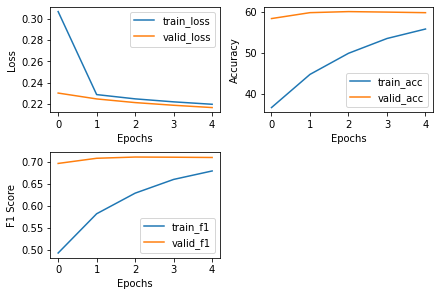

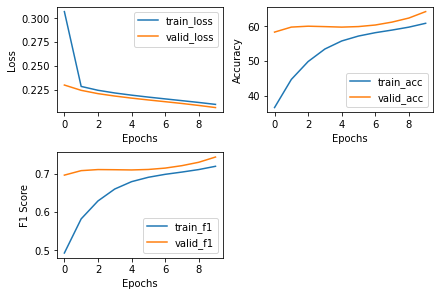

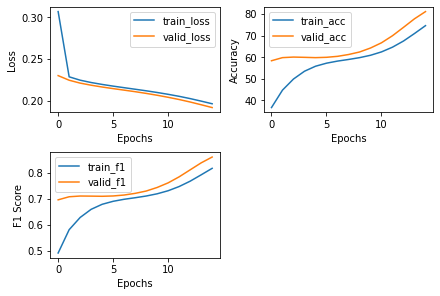

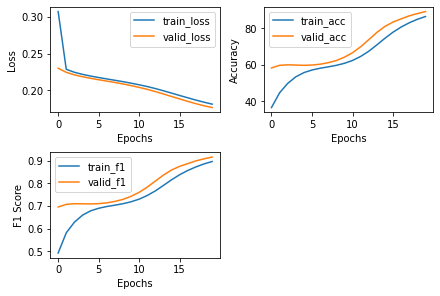

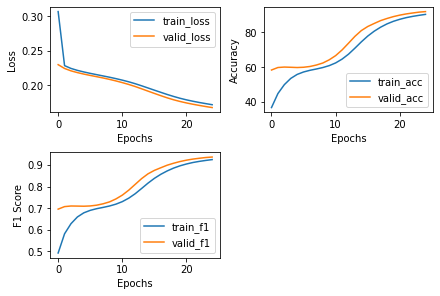

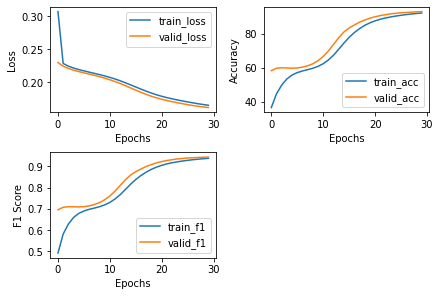

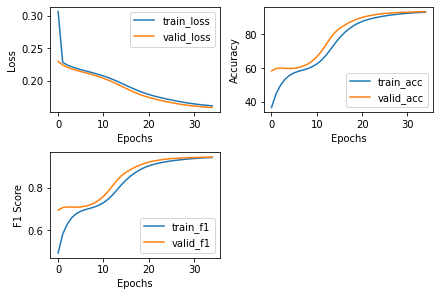

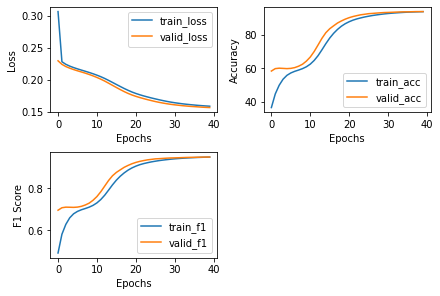

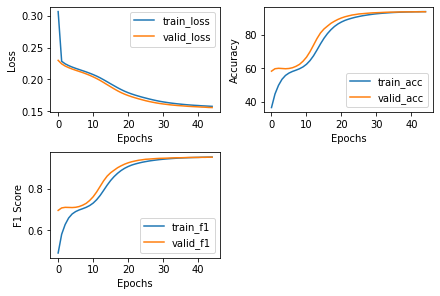

In [29]:
model, history = CallsTrain(model, training_loader, testing_loader, Epochs = 50, name = '/content/drive/MyDrive/punctuation data/Aze2_Bert.pt')

Text(0.5, 1.0, 'Training and Validation F1')

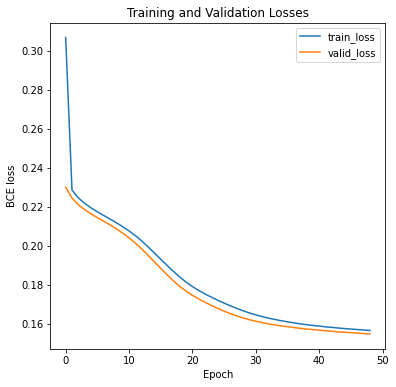

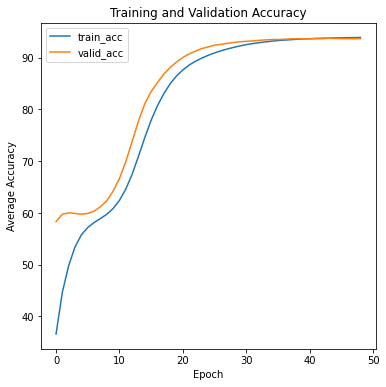

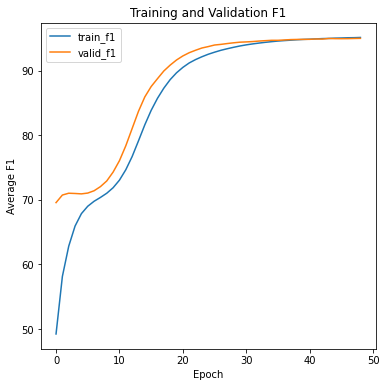

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('BCE loss')
plt.title('Training and Validation Losses')

plt.figure(figsize=(6, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(
        100 * history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')

plt.figure(figsize=(6, 6))
for c in ['train_f1', 'valid_f1']:
    plt.plot(
        100 * history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average F1')
plt.title('Training and Validation F1')

In [ ]:
history.to_csv('./drive/MyDrive/history.csv')

In [ ]:
device = torch.device("cpu")
model.to(device)
test = "aliyeva zemfira musakızı, yılının. "
processed_test = tokenizer(list(test), truncation=True, is_split_into_words=True)
x = torch.tensor(processed_test['input_ids'], dtype=torch.long)
y = torch.tensor(processed_test['attention_mask'], dtype=torch.long)
x = torch.unsqueeze(x, dim=0)
y = torch.unsqueeze(y, dim=0)

In [ ]:
# def validation(epoch, data_loader):
#     # model2.eval()
#     fin_targets=[]
#     fin_outputs=[]
#     softm = torch.nn.Softmax(dim=1)
#     with torch.no_grad():
#         for _, data in enumerate(data_loader, 0):
#             # start_time = time.time()
#             ids = data['ids'].to(device, dtype = torch.long)
#             mask = data['mask'].to(device, dtype = torch.long)
#             # token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
#             targets = data['targets'].to(device, dtype = torch.long)
#             outputs = model(ids, mask)
#             fin_targets.extend(targets.cpu().detach().numpy().tolist())
#             fin_outputs.extend(torch.argmax(softm(outputs.logits),dim=1).cpu().detach().numpy().tolist())
#             # print("--- %s seconds ---" % (time.time() - start_time))
#     return outputs, fin_outputs, fin_targets

In [ ]:
softm = torch.nn.Softmax(dim=1)
ids = x.to(device, dtype = torch.long)
mask = y.to(device, dtype = torch.long)
outputs = model(ids, mask)
print(outputs.logits.shape)
fin_outputs = (torch.argmax(softm(outputs.logits),dim=2).cpu().detach().numpy())

In [ ]:
xx = tokenizer.tokenize(test)

In [ ]:
fin_outputs.shape

In [ ]:
indexed_tokens = tokenizer.convert_tokens_to_string(xx)
indexed_tokens